
# Ridge Regression – Migration Project (Quick Student Notebook)

This notebook runs a **Ridge regression** on the migration panel data using `sklearn`,
with a **time-based train/test split** and a short, informal interpretation in French.


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Sklearn Ridge regression for migration_rate
Pattern: split -> scale -> model -> fit -> predict -> evaluate
"""

from pathlib import Path
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Load and trying to prepare the data
ROOT = Path("/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics")
DATA_PATH = ROOT / "data" / "databasecsv.csv"
df = pd.read_csv(DATA_PATH, sep=";")
df.columns = df.columns.str.strip()
print(f"Loaded {len(df)} rows")

# Base variables
base_vars = [
    "log_rent_avg",
    "log_avg_income",
    "log_unemployment",
    "log_schockexposure",
    "CLUSTER1",
    "CLUSTER2",
]

# Interactions
df["log_avg_income_x_log_rent_avg"] = df["log_avg_income"] * df["log_rent_avg"]
df["log_unemployment_rate_x_log_avg_income"] = df["log_unemployment"] * df["log_avg_income"]
df["log_schockexposure_x_CLUSTER1"] = df["log_schockexposure"] * df["CLUSTER1"]
df["log_schockexposure_x_CLUSTER2"] = df["log_schockexposure"] * df["CLUSTER2"]

interaction_vars = [
    "log_avg_income_x_log_rent_avg",
    "log_unemployment_rate_x_log_avg_income",
    "log_schockexposure_x_CLUSTER1",
    "log_schockexposure_x_CLUSTER2",
]

required_cols = ["migration_rate", "canton", "year"] + base_vars + interaction_vars
df_model = df.dropna(subset=required_cols).copy()
print(f"After initial cleaning: {len(df_model)} rows")

# Canton dummies 
df_model = pd.get_dummies(df_model, columns=["canton"], drop_first=True)

# Ensure year is numeric for chronological split
df_model["year"] = pd.to_numeric(df_model["year"], errors="coerce")

# Final feature list
feature_cols = base_vars + interaction_vars + [c for c in df_model.columns if c.startswith("canton_")]

# Explicit numeric coercion
X_df = df_model[feature_cols].apply(pd.to_numeric, errors="coerce")
y_ser = pd.to_numeric(df_model["migration_rate"], errors="coerce")

# Drop invalid rows
mask_valid = (~X_df.isna().any(axis=1)) & (~y_ser.isna()) & (~df_model["year"].isna())
before = len(df_model)
X_df = X_df.loc[mask_valid]
y_ser = y_ser.loc[mask_valid]
df_model = df_model.loc[mask_valid].copy()
after = len(df_model)
print(f"Rows kept after numeric coercion: {after} (dropped {before-after})")

# times based train-test split
df_sorted = df_model.sort_values(["year"]).reset_index(drop=True)
years = df_sorted["year"].unique()
cut = int(0.8 * len(years)) if len(years) > 1 else 1

train_years = set(years[:cut])
test_years = set(years[cut:]) if cut < len(years) else set()


X_train = df_sorted.loc[df_sorted["year"].isin(train_years), feature_cols].apply(pd.to_numeric, errors="coerce").to_numpy()
y_train = pd.to_numeric(df_sorted.loc[df_sorted["year"].isin(train_years), "migration_rate"], errors="coerce").to_numpy()
X_test  = df_sorted.loc[df_sorted["year"].isin(test_years),  feature_cols].apply(pd.to_numeric, errors="coerce").to_numpy()
y_test  = pd.to_numeric(df_sorted.loc[df_sorted["year"].isin(test_years),  "migration_rate"], errors="coerce").to_numpy()

print("Split shapes ->",
      "X_train", X_train.shape, "X_test", X_test.shape,
      "y_train", y_train.shape, "y_test", y_test.shape)

#standardized scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# loop over different lambdas
lambdas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

print("\n=== Ridge results (time-based test) ===")
best_alpha = None
best_r2 = -1e9
results = []

for alpha in lambdas:
    model = Ridge(alpha=alpha)  # alpha = lambda
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append((alpha, mse, r2))
    print(f"lambda={alpha:>7.4f}  MSE={mse:8.4f}  R^2={r2:8.4f}")

    if r2 > best_r2:
        best_r2 = r2
        best_alpha = alpha

print(f"\nBest lambda based on test R^2: {best_alpha} (R^2 = {best_r2:.4f})")

# refit best model and show some predictions
best_model = Ridge(alpha=best_alpha)
best_model.fit(X_train_scaled, y_train)
y_pred_best = best_model.predict(X_test_scaled)

print("\nFirst 5 predictions vs true (best Ridge):")
for yp, yt in list(zip(y_pred_best[:5], y_test[:5])):
    print(f"pred={yp:.3f} | true={yt:.3f}")


Loaded 285 rows
After initial cleaning: 260 rows
Rows kept after numeric coercion: 260 (dropped 0)
Split shapes -> X_train (208, 35) X_test (52, 35) y_train (208,) y_test (52,)

=== Ridge results (time-based test) ===
lambda= 0.0000  MSE=  0.0683  R^2=  0.3511
lambda= 0.0001  MSE=  0.0575  R^2=  0.4536
lambda= 0.0010  MSE=  0.0445  R^2=  0.5772
lambda= 0.0100  MSE=  0.0452  R^2=  0.5702
lambda= 0.1000  MSE=  0.0443  R^2=  0.5789
lambda= 1.0000  MSE=  0.0423  R^2=  0.5983
lambda=10.0000  MSE=  0.0429  R^2=  0.5923

Best lambda based on test R^2: 1.0 (R^2 = 0.5983)

First 5 predictions vs true (best Ridge):
pred=-0.102 | true=-0.180
pred=0.003 | true=0.210
pred=0.326 | true=0.370
pred=-0.186 | true=0.090
pred=-0.538 | true=-0.460


ROOT = /Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics/


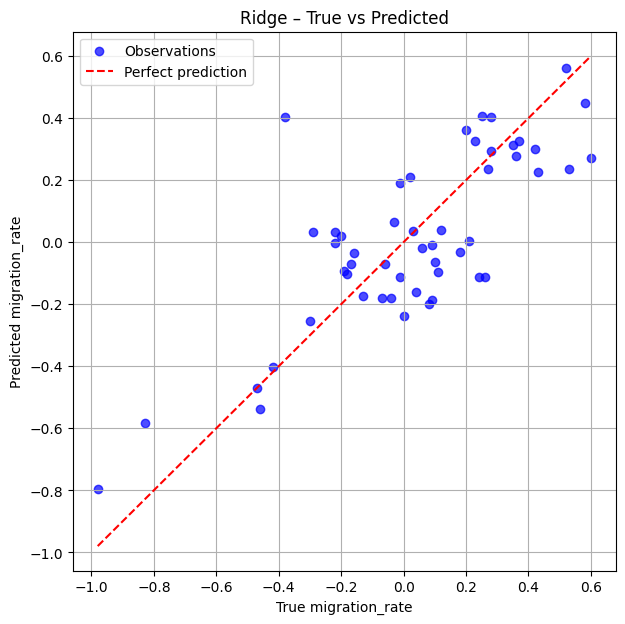

In [11]:
from pathlib import Path
import sys

ROOT = "/Users/maximeducotterd/Desktop/DSAP_intercantonal_dynamics/"
print("ROOT =", ROOT)

from src.ML.ridge.plotridge import plot_true_vs_pred

plot_true_vs_pred(y_test, y_pred_best)